In [1]:
import numpy as np
import pandas as pd
import open3d as o3d

import open3d as o3d
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.spatial import Delaunay
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
# Function to create transects based on theta2 values
def create_transects(dataframe, target_theta2_values, theta_range=1):
    return [dataframe[(dataframe['theta'] >= t - theta_range) & (dataframe['theta'] <= t + theta_range)] for t in target_theta2_values]

# Function to transform lidar point cloud to system coordinates
def transform_lidar(pcd_file, transformation_matrix):
    # Load point cloud data
    pcd = o3d.io.read_point_cloud(pcd_file)
    xyz = np.asarray(pcd.points)

    # Convert to spherical coordinates
    rho = np.linalg.norm(xyz, axis=1)
    theta_degrees = np.degrees(np.arccos(xyz[:, 2] / rho))

    # Create DataFrame with point cloud data and theta values
    point_cloud_df = pd.DataFrame(xyz, columns=['x', 'y', 'z'])
    point_cloud_df['theta'] = theta_degrees

    # Define target theta2 values and generate transects
    target_theta2_values = [97.2, 92.5, 90.0, 87.6, 84.9, 82.7, 80.4, 77.9, 75.7, 73.0, 70.9, 68.0, 66.0, 63.4, 60.9, 55.7]
    transects = create_transects(point_cloud_df, target_theta2_values)

    # Check for unassigned points
    unassigned_points_count = len(point_cloud_df) - sum(len(transect) for transect in transects)
    if unassigned_points_count > 0:
        print(f"Unassigned points count: {unassigned_points_count}")

    # Select Transect 3 and remove lidar frame points
    transect_A = transects[2]
    transect_A = transect_A[~(
        ((transect_A['y'] >= -600) & (transect_A['y'] <= 100) & 
         (transect_A['x'] >= -1000) & (transect_A['x'] <= 4000)) |
        (transect_A['x'] < -2000)
    )]

    # Apply transformation matrix to go to RD coordinates
    homogeneous_coords = np.hstack((transect_A[['x', 'y', 'z']], np.ones((transect_A.shape[0], 1))))
    transformed_coords = homogeneous_coords.dot(transformation_matrix.T)

    # Store transformed coordinates in DataFrame df_RD
    df_RD = pd.DataFrame(transformed_coords[:, :3], columns=['x', 'y', 'z'])

    # Define offset for system coordinates
    offset = [71683.5843540416, 452356.054802959]
    angle_rad = np.radians(36)
    cos_angle, sin_angle = np.cos(angle_rad), np.sin(angle_rad)

    # Transform to system coordinates
    df = pd.DataFrame({
        'x': (df_RD['x'] - offset[0]) * cos_angle - (df_RD['y'] - offset[1]) * sin_angle,
        'y': (df_RD['x'] - offset[0]) * sin_angle + (df_RD['y'] - offset[1]) * cos_angle,
        'z': df_RD['z']
    })

    return df



In [14]:
### S1 Dike in dune ###
offset = [71683.5843540416, 452356.054802959]
angle_rad = np.radians(36)
cos_angle, sin_angle = np.cos(angle_rad), np.sin(angle_rad)

# dike section
teen = [72494.97, 452125.915, 1.08]
kruin = [72504.20, 452119.20, 4.77]

teen_ns = [0, 0, 0]
kruin_ns = [0, 0, 0]

teen_ns[0] = (teen[0] - offset[0]) * cos_angle - (teen[1] - offset[1]) * sin_angle
teen_ns[1] = (teen[0] - offset[0]) * sin_angle + (teen[1] - offset[1]) * cos_angle
teen_ns[2] = teen[2]

kruin_ns[0] = (kruin[0] - offset[0]) * cos_angle - (kruin[1] - offset[1]) * sin_angle
kruin_ns[1] = (kruin[0] - offset[0]) * sin_angle + (kruin[1] - offset[1]) * cos_angle
kruin_ns[2] = kruin[2]

print(teen_ns)
print(kruin_ns)

[791.6975587170695, 290.7335049401803, 1.08]
[803.1117635442716, 290.726213701636, 4.77]


In [3]:
# Transformation matrix storm 1
transformation_matrix1 = np.array([
    [-0.000024980998,  0.000812676153, -0.000583815563,  492.143829345703],
    [ 0.000007067249, -0.000583839603, -0.000813012011,  127.397300720215],
    [-0.001000616350, -0.000024412553,  0.000008833092,    4.558271408081],
    [ 0.000000000000,  0.000000000000,  0.000000000000,    1.000000000000]
])
transformation_matrix1[0,3]+=  72000.00 
transformation_matrix1[1,3]+=  452000.00

# Transformation matrix storm 2
transformation_matrix2 = np.array([
    [-0.000024980998,  0.000812676153, -0.000583815563, 492.143829345703],
    [0.000007067249, -0.000583839603, -0.000813012011, 127.397300720215],
    [-0.001000616350, -0.000024412553, 0.000008833092, 4.558271408081],
    [0.000000000000,  0.000000000000,  0.000000000000, 1.000000000000]
])
transformation_matrix2[0,3]+=  72000.00 
transformation_matrix2[1,3]+=  452000.00

# Transformation matrix storm 3
# Transformation matrix storm 4
# Transformation matrix storm 5


In [4]:
# Storm 2 
pcd_file2_1 = r"U:\2024-12-22, Storm 2\Lidars\20241223_LiDAR1\10s interval data\Lidar1__Pcl_0022_12_2024__02_30_30.030.PCD"
pcd_file2_2 = r"U:\2024-12-22, Storm 2\Lidars\20241223_LiDAR1\10s interval data\Lidar1__Pcl_0022_12_2024__14_30_30.030.PCD"
pcd_file2_3 = r"U:\2024-12-22, Storm 2\Lidars\20241223_LiDAR1\10s interval data\Lidar1__Pcl_0023_12_2024__01_30_30.030.PCD"

df2_1 = transform_lidar(pcd_file2_1, transformation_matrix2)
df2_2 = transform_lidar(pcd_file2_2, transformation_matrix2)
df2_3 = transform_lidar(pcd_file2_3, transformation_matrix2)

In [5]:
df2_1['x']

0      773.787251
1      775.566367
2      776.039919
3      776.576759
4      776.933449
          ...    
265    810.382930
266    810.675287
267    811.051775
268    811.416266
269    811.756694
Name: x, Length: 270, dtype: float64

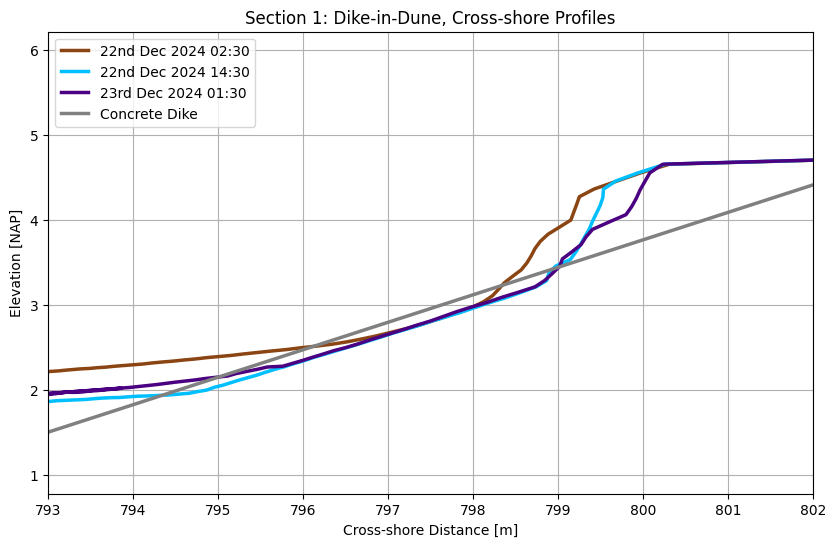

In [26]:
# Plot the transformed transects
plt.figure(figsize=(10, 6))

# Plot each dataframe
plt.plot(df2_1['x'], df2_1['z'], color='saddlebrown', linewidth=2.5, label='22nd Dec 2024 02:30')
plt.plot(df2_2['x'], df2_2['z'], color='deepskyblue', linewidth=2.5, label='22nd Dec 2024 14:30')
plt.plot(df2_3['x'], df2_3['z'], color='indigo', linewidth=2.5, label='23rd Dec 2024 01:30')

# Plot line through teen_ns and kruin_ns
x = [teen_ns[0], kruin_ns[0]]
y = [teen_ns[2], kruin_ns[2]]
plt.plot(x, y, color='grey', linewidth=2.5, label='Concrete Dike')

plt.xlabel('Cross-shore Distance [m]')
plt.ylabel('Elevation [NAP]')
plt.title('Section 1: Dike-in-Dune, Cross-shore Profiles')
plt.grid(True)
plt.gca().set_aspect('equal', adjustable='box')
plt.legend(loc='upper left')

plt.xlim(793, 802)

plt.show()